In [1]:
import os
import _pickle as pickle
import os
from datetime import datetime
from collections import OrderedDict
import pandas as pd
import numpy as np
import copy
import itertools

In [2]:
class EHRParser:
    def __init__(self, path):
        self.path = path
        self.admission_csv = ''
        self.diagnosis_csv = ''
        self.admission_cols = {
            'pid': None,
            'adm_id': None,
            'adm_time': None
        }
        self.diagnosis_cols = {
            'pid': None,
            'adm_id': None,
            'cid': None
        }
        self.skip_pid_check = False
        self.patient_admission = None
        self.admission_codes = None

        self.admission_col_converter = self.set_admission_col()
        self.diagnosis_col_converter = self.set_diagnosis_col()

    def set_admission_col(self) -> dict:
        raise NotImplementedError

    def set_diagnosis_col(self) -> dict:
        raise NotImplementedError

    def to_standard_icd9(self, code: str):
        raise NotImplementedError

    def parse_admission(self):
        print('parsing the csv file of admission ...')
        admission_path = os.path.join(self.path, self.admission_csv)
        admissions = pd.read_csv(
            admission_path,
            usecols=list(self.admission_cols.values()),
            converters=self.admission_col_converter
        )
        all_patients = OrderedDict()
        for i, row in admissions.iterrows():
            if i % 100 == 0:
                print('\r\t%d in %d rows' % (i + 1, len(admissions)), end='')
            pid = row[self.admission_cols['pid']]
            admission_id = row[self.admission_cols['adm_id']]
            admission_time = row[self.admission_cols['adm_time']]
            if pid not in all_patients:
                all_patients[pid] = []
            admission = all_patients[pid]
            admission.append({
                'admission_id': admission_id,
                'admission_time': admission_time
            })
        print('\r\t%d in %d rows' % (len(admissions), len(admissions)))

        patient_admission = OrderedDict()
        for pid, admissions in all_patients.items():
            patient_admission[pid] = sorted(admissions, key=lambda admission: admission['admission_time'])

        self.patient_admission = patient_admission

    def parse_diagnoses(self):
        print('parsing csv file of diagnosis ...')
        diagnoses_path = os.path.join(self.path, self.diagnosis_csv)
        diagnoses = pd.read_csv(
            diagnoses_path,
            usecols=list(self.diagnosis_cols.values()),
            converters=self.diagnosis_col_converter
        )

        admission_codes = OrderedDict()
        for i, row in diagnoses.iterrows():
            if i % 100 == 0:
                print('\r\t%d in %d rows' % (i + 1, len(diagnoses)), end='')
            pid = row[self.diagnosis_cols['pid']]
            if self.skip_pid_check or pid in self.patient_admission:
                admission_id = row[self.diagnosis_cols['adm_id']]
                code = row[self.diagnosis_cols['cid']]
                code = self.to_standard_icd9(code)
                if code == '':
                    continue
                if admission_id not in admission_codes:
                    codes = []
                    admission_codes[admission_id] = codes
                else:
                    codes = admission_codes[admission_id]
                codes.append(code)
        print('\r\t%d in %d rows' % (len(diagnoses), len(diagnoses)))

        self.admission_codes = admission_codes

        self.after_parse_diagnosis()

    def after_parse_diagnosis(self):
        pass

    def calibrate_patient_by_admission(self):
        print('calibrating patients by admission ...')
        del_pids = []
        for pid, admissions in self.patient_admission.items():
            for admission in admissions:
                if admission['admission_id'] not in self.admission_codes:
                    break
            else:
                continue
            del_pids.append(pid)
        for pid in del_pids:
            admissions = self.patient_admission[pid]
            for admission in admissions:
                if admission['admission_id'] in self.admission_codes:
                    del self.admission_codes[admission['admission_id']]
                else:
                    # print('\tpatient %d have an admission %d without diagnosis' % (pid, admission['admission_id']))
                    pass
            del self.patient_admission[pid]

    def parse(self):
        self.parse_admission()
        self.parse_diagnoses()
        self.calibrate_patient_by_admission()
        return self.patient_admission, self.admission_codes

In [3]:
def encode_code(patient_admission: dict, admission_codes: dict) -> (dict, dict, dict):
    print('encoding code ...')
    code_map = OrderedDict()
    for pid, admissions in patient_admission.items():
        if len(admissions) <= 2:
            continue
        for admission in admissions:
            codes = admission_codes[admission['admission_id']]
            for code in codes:
                if code not in code_map:
                    code_map[code] = len(code_map) + 1
    code_map_pretrain = copy.deepcopy(code_map)
    for pid, admissions in patient_admission.items():
        if len(admissions) > 2:
            continue
        for admission in admissions:
            codes = admission_codes[admission['admission_id']]
            for code in codes:
                if code not in code_map_pretrain:
                    code_map_pretrain[code] = len(code_map_pretrain) + 1

    admission_codes_encoded = {
        admission_id: [code_map_pretrain[code] for code in codes]
        for admission_id, codes in admission_codes.items()
    }
    return admission_codes_encoded, code_map, code_map_pretrain

In [4]:
class MentalParser(EHRParser):
    def __init__(self, path):
        super().__init__(path)
        self.admission_csv = 'ADMISSIONS.csv'
        self.diagnosis_csv = 'DIAGNOSES_ICD.csv'

    def set_admission_col(self) -> dict:
        self.admission_cols['pid'] = 'SUBJECT_ID'
        self.admission_cols['adm_id'] = 'HADM_ID'
        self.admission_cols['adm_time'] = 'ADMITTIME'
        converter = {
            'SUBJECT_ID': int,
            'HADM_ID': int,
            'ADMITTIME': lambda cell: datetime.strptime(str(cell), '%Y-%m-%d')
        }
        return converter

    def set_diagnosis_col(self) -> dict:
        self.diagnosis_cols['pid'] = 'SUBJECT_ID'
        self.diagnosis_cols['adm_id'] = 'HADM_ID'
        self.diagnosis_cols['cid'] = 'ICD10_CODE'
        converter = {'SUBJECT_ID': int, 'HADM_ID': int, 'ICD10_CODE': str}
        return converter

    def to_standard_icd9(self, code: str):
        if code == '':
            return code
        split_pos = 3
        icd9_code = code[:split_pos] + '.' + code[split_pos+1:split_pos+2]
        return icd9_code

In [5]:
if __name__ == '__main__':
    conf = {
        'Mental': {
            'parser': MentalParser,

        },
    }
    data_path = '../data'
    dataset = 'Mental'  
    # dataset_path = os.path.join(data_path, dataset)
    raw_path = os.path.join(data_path, 'raw')
    if not os.path.exists(raw_path):
        os.makedirs(raw_path)
        print('please put the CSV files in `data/%s/raw`' % dataset)
        exit()
    parser = conf[dataset]['parser'](raw_path)
    patient_admission, admission_codes = parser.parse()

    print('There are %d valid patients' % len(patient_admission))

    max_admission_num = max([len(admissions) for admissions in patient_admission.values()])
    max_code_num_in_a_visit = max([len(codes) for codes in admission_codes.values()])
    print('max admission num: %d, max code num in an admission: %d' % (max_admission_num, max_code_num_in_a_visit))
    # 对具有多次入院的患者遍历其入院次数，对医疗代码进行编码，编码存储在 code_map 中。
    # 对只有一次入院的患者进行类似的遍历和编码，编码存储在 code_map_pretrain 中。
    # 使用 code_map_pretrain 对所有患者的医疗代码进行编码，生成 admission_codes_encoded。
    admission_codes_encoded, code_map, code_map_pretrain = encode_code(patient_admission, admission_codes)

    code_num = len(code_map)
    code_num_pretrain = len(code_map_pretrain)
    print('There are %d pretrain codes, %d codes in multiple visits' % (code_num_pretrain, code_num))

parsing the csv file of admission ...
	271980 in 271980 rows
parsing csv file of diagnosis ...
	1315701 in 1315701 rows
calibrating patients by admission ...
There are 102171 valid patients
max admission num: 50, max code num in an admission: 16
encoding code ...
There are 4930 pretrain codes, 4516 codes in multiple visits


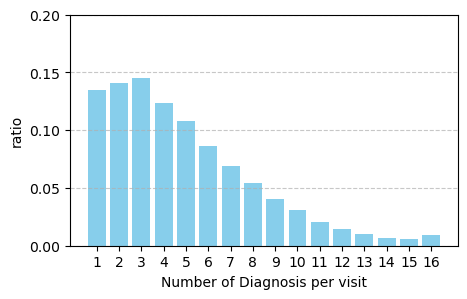

In [6]:
per_visit = [len(codes) for codes in admission_codes.values()]
import matplotlib.pyplot as plt
from collections import Counter

# 给定的数字列表
numbers = per_visit

# 计算每个数字的频率
frequency = Counter(numbers)
total_count = sum(frequency.values())

# 计算每个数字出现的百分比
percentages = {num: (count / total_count)  for num, count in frequency.items()}

# 准备绘图数据
labels, percents = zip(*percentages.items())

# 绘制百分比分布图
plt.figure(figsize=(5, 3))
plt.bar(labels, percents, color='skyblue')
plt.xlabel('Number of Diagnosis per visit')
plt.ylabel('ratio')
# plt.title('数字出现百分比分布')
plt.xticks(labels)
plt.yticks(np.arange(0, 0.25, 0.05))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [18]:
frequency

Counter({4: 33554,
         5: 29293,
         8: 14805,
         6: 23374,
         7: 18724,
         9: 10869,
         10: 8349,
         1: 36555,
         2: 38149,
         3: 39221,
         15: 1469,
         16: 2399,
         12: 3982,
         11: 5636,
         14: 1764,
         13: 2653})

In [20]:
product_sum = sum(key * value for key, value in frequency.items())
product_sum / total_count

4.843660910796319

In [21]:
total_count

270796

In [6]:
def split_patients(patient_admission: dict,
                   admission_codes: dict,
                   code_map: dict,
                   seed=6669) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray): # type: ignore
    print('splitting pretrain, train, valid, and test pids ...')
    single = []
    multiple = []
    for pid, admissions in patient_admission.items():
        if len(admissions) > 2:
            multiple.append(pid)
        else:
            single.append(pid)
    print('There are %d single+ admission patients, %d multiple admission patients' % (len(single), len(multiple)))
    np.random.seed(seed)
    common_pids = set()
    for i, code in enumerate(code_map):
        print('\r\t%.2f%%' % ((i + 1) * 100 / len(code_map)), end='')
        for pid in multiple:
            admissions = patient_admission[pid]
            for admission in admissions:
                codes = admission_codes[admission['admission_id']]
                if code in codes:
                    common_pids.add(pid)
                    break
            else:
                continue
            break
    print('\r\t100%')

    pid_max_admission_num, _ = max([(pid, len(patient_admission[pid])) for pid in multiple], key=lambda x: x[1])
    common_pids.add(pid_max_admission_num)
    remaining_pids = np.array(list(set(multiple).difference(common_pids)))
    np.random.shuffle(remaining_pids)

    train_num = int(len(multiple) * 0.7)
    test_num = int(len(multiple) * 0.2)
    valid_num = len(multiple) - train_num - test_num
    train_pids = np.array(list(common_pids.union(set(remaining_pids[:(train_num - len(common_pids))].tolist()))))
    valid_pids = remaining_pids[(train_num - len(common_pids)):(train_num + valid_num - len(common_pids))]
    test_pids = remaining_pids[(train_num + valid_num - len(common_pids)):]
    pretrain_pids = np.concatenate([np.array(single), train_pids])
    return pretrain_pids, train_pids, valid_pids, test_pids, single, multiple


In [7]:
if __name__ == '__main__':
    pretrain_pids, train_pids, valid_pids, test_pids, single, multiple = split_patients(
        patient_admission=patient_admission,
        admission_codes=admission_codes,
        code_map=code_map,

    )
    # prtrain是单次+多次train
    print('There are %d pretrain, %d train, %d valid, %d test samples' %
          (len(pretrain_pids), len(train_pids), len(valid_pids), len(test_pids)))

splitting pretrain, train, valid, and test pids ...
There are 74629 single+ admission patients, 27542 multiple admission patients
	100%00%
There are 93908 pretrain, 19279 train, 2755 valid, 5508 test samples


In [8]:
len(multiple)

27542

In [9]:
tes_adm = pd.read_csv('../data/raw/ADMISSIONS.csv')
# 将特定值赋为空值
# tes_icd.replace(np.nan, 'None', inplace=True)  # 将所有 '' 替换为nan
test_adm = tes_adm[tes_adm.SUBJECT_ID.isin(multiple)]
test_adm.reset_index(drop=True, inplace=True)
print(test_adm.shape)
tes_icd = pd.read_csv('../data/raw/DIAGNOSES_ICD.csv')
# 将特定值赋为空值
# tes_icd.replace(np.nan, 'None', inplace=True)  # 将所有 '' 替换为nan
test_icd = tes_icd[tes_icd.SUBJECT_ID.isin(multiple)]
test_icd.reset_index(drop=True, inplace=True)
print(test_icd.shape)

/tmp/ipykernel_112383/3326838971.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  tes_adm = pd.read_csv('../data/raw/ADMISSIONS.csv')


(180444, 10)
(917809, 5)


In [10]:
len(test_icd)/len(test_adm)

5.086392454168607

In [11]:
len(test_adm) / len(multiple)

6.551593929271657

In [12]:
print(multiple)

[3, 10, 13, 16, 18, 21, 22, 35, 41, 53, 57, 63, 65, 66, 68, 74, 79, 85, 87, 97, 104, 107, 111, 123, 145, 151, 161, 163, 165, 178, 185, 186, 193, 197, 207, 217, 231, 236, 238, 267, 269, 284, 285, 297, 300, 303, 329, 339, 340, 342, 344, 347, 349, 351, 353, 371, 378, 390, 392, 398, 438, 443, 445, 446, 448, 449, 470, 474, 475, 489, 500, 501, 527, 545, 559, 564, 575, 584, 587, 600, 602, 616, 619, 620, 621, 650, 652, 653, 670, 672, 678, 719, 724, 742, 750, 762, 765, 770, 773, 774, 778, 781, 796, 827, 829, 837, 842, 855, 868, 869, 876, 879, 880, 884, 899, 903, 909, 916, 929, 947, 954, 955, 957, 963, 968, 973, 978, 979, 980, 981, 983, 986, 987, 993, 994, 999, 1002, 1008, 1018, 1019, 1021, 1022, 1029, 1033, 1034, 1035, 1037, 1038, 1043, 1046, 1051, 1056, 1058, 1061, 1063, 1073, 1087, 1092, 1093, 1095, 1101, 1108, 1121, 1131, 1135, 1141, 1144, 1147, 1148, 1154, 1156, 1158, 1161, 1165, 1172, 1173, 1174, 1178, 1189, 1195, 1198, 1199, 1201, 1202, 1203, 1207, 1211, 1217, 1218, 1222, 1231, 1241, 1243

In [13]:
import pickle

# 打开.pkl文件
with open('./Mental/node_embeddings10.pkl', 'rb') as file:
    # 使用pickle.load()读取文件内容
    patient_embeddings = pickle.load(file)

# 现在node_embeddings变量包含了.pkl文件中的数据
print(patient_embeddings.shape)

(27542, 64)


In [14]:
patient_embeddings

array([[-0.28441083,  0.2384652 ,  0.05291691, ...,  0.14153619,
        -0.1459547 , -0.05946816],
       [ 0.26169717,  0.6295254 , -0.17321129, ..., -0.7328737 ,
        -0.4345008 ,  0.02331722],
       [-0.9158436 , -0.11965816,  0.77676946, ..., -2.0127282 ,
         0.5279438 ,  0.47199234],
       ...,
       [ 0.06076777,  1.0658503 , -1.7489607 , ...,  0.00569094,
         0.89993006, -0.0580528 ],
       [ 0.09550821, -0.6118945 , -0.7460353 , ...,  0.5227377 ,
        -0.14507967, -0.5843255 ],
       [-0.58699745,  0.20087516, -0.11097392, ...,  0.19754507,
         0.2158717 , -0.16281731]], dtype=float32)

In [15]:
def build_code_xy(pids: np.ndarray,
                  patient_admission: dict,
                  admission_codes_encoded: dict,
                  max_admission_num: int,
                  code_num: int,
                  max_code_num_in_a_visit: int,
                  pretrain=False) -> (np.ndarray, np.ndarray, np.ndarray): # type: ignore
    print('building pretrain/train/valid/test codes features and labels ...')
    n = len(pids)
    print(max_admission_num)
    x = np.zeros((n, max_admission_num-1, max_code_num_in_a_visit), dtype=int)
    y = np.zeros((n, code_num), dtype=int)
    embeddings = np.zeros((n, 64), dtype=np.float32)
    lens = np.zeros((n, ), dtype=int)
    intervals = np.zeros((n, max_admission_num-1), dtype=int)  # Added for intervals
    for i, pid in enumerate(pids):
        print('\r\t%d / %d' % (i + 1, len(pids)), end='')
        admissions = patient_admission[pid]
        end_pos = None if pretrain and len(admissions) <= 2 else -1
        for k, admission in enumerate(admissions[:end_pos]):
            codes = admission_codes_encoded[admission['admission_id']]
            x[i][k][:len(codes)] = codes
            # Calculate interval for each admission (except the first one)
            if end_pos == -1:
                interval = (admissions[k+1]['admission_time'] - admissions[k]['admission_time']).days
                intervals[i][k] = interval
        if pretrain:
            codes = set(itertools.chain.from_iterable([admission_codes_encoded[admission['admission_id']]
                                                    for admission in admissions]))
            codes = np.array(list(codes)) - 1
        else:
            codes = np.array(admission_codes_encoded[admissions[-1]['admission_id']]) - 1    
        # 如果是预训练模式（pretrain=True），将所有就诊记录中出现的诊断编码合并为一个集合，将集合中的诊断编码减去1(-1对应原先代码)，并赋值给codes。
        # 这样，codes中的元素表示所有出现的诊断编码的唯一标识符。
        # 这是为了构建一个预训练任务，预测患者是否会在未来的就诊记录中出现特定的诊断编码。
        # codes = [admissions[-1]['admission_id']]
        # print(codes)
        y[i][codes] = 1
        lens[i] = len(admissions) if pretrain else len(admissions) - 1
        
        embeddings[i] = patient_embeddings[multiple.index(pid)] if pid in multiple else np.zeros((1, 64))
        
    print('\r\t%d / %d' % (len(pids), len(pids)))
    return x, intervals, y, lens, embeddings

In [16]:
pretrain_codes_x, pretrain_codes_intervals, pretrain_codes_y, pretrain_visit_lens, pre_embeddings = build_code_xy(pretrain_pids, patient_admission,
                                                                            admission_codes_encoded, max_admission_num,
                                                                            code_num_pretrain, max_code_num_in_a_visit,
                                                                            pretrain=True)
train_codes_x, train_codes_intervals, train_codes_y, train_visit_lens, train_embeddings = build_code_xy(train_pids, patient_admission,
                                                                   admission_codes_encoded, max_admission_num,
                                                                   code_num, max_code_num_in_a_visit)
valid_codes_x, valid_codes_intervals, valid_codes_y, valid_visit_lens, valid_embeddings = build_code_xy(valid_pids, patient_admission,
                                                                   admission_codes_encoded, max_admission_num,
                                                                   code_num, max_code_num_in_a_visit)
test_codes_x, test_codes_intervals, test_codes_y, test_visit_lens, test_embeddings = build_code_xy(test_pids, patient_admission, admission_codes_encoded,
                                                                max_admission_num, code_num,
                                                                max_code_num_in_a_visit)

building pretrain/train/valid/test codes features and labels ...
50
	93908 / 93908
building pretrain/train/valid/test codes features and labels ...
50
	19279 / 19279
building pretrain/train/valid/test codes features and labels ...
50
	2755 / 2755
building pretrain/train/valid/test codes features and labels ...
50
	5508 / 5508


In [17]:
def build_hf_y(target_prefixes: list, codes_y: np.ndarray, code_map: dict) -> np.ndarray:
    print('building train/valid/test Target_Disease labels ...')
    # target_list = np.array([cid for code, cid in code_map.items() if code.startswith(target_prefix)])
    # targets = np.zeros((len(code_map), ), dtype=int)
    # targets[target_list - 1] = 1
    # target_exist = np.logical_and(codes_y, targets)
    # y = (np.sum(target_exist, axis=-1) > 0).astype(int)
    # return y
    # 初始化一个全零的数组
    targets = np.zeros((len(code_map),), dtype=int)
    
    # 对每个前缀进行迭代
    for target_prefix in target_prefixes:
        # 找到与当前前缀匹配的代码
        target_list = np.array([cid for code, cid in code_map.items() if code.startswith(target_prefix)], dtype=int)
        # 将匹配的代码对应位置设为1
        targets[target_list - 1] = 1

    # 判断是否存在心力衰竭相关代码
    target_exist = np.logical_and(codes_y, targets)
    # 判断是否存在任何心力衰竭相关代码
    y = (np.sum(target_exist, axis=-1) > 0).astype(int)
    
    return y
# hf_ICD = ['I11.0', 'I11.9', 'I13.0', 'I13.2', 'I50', 'I97.1', 'I97.8']
# train_hf_y = build_hf_y(hf_ICD, train_codes_y, code_map)
# valid_hf_y = build_hf_y(hf_ICD, valid_codes_y, code_map)
# test_hf_y = build_hf_y(hf_ICD, test_codes_y, code_map)

# da_ICD = ['E10', 'E11', 'E12', 'E13', 'E14', 'E71.0', 'P70']
# train_da_y = build_hf_y(da_ICD, train_codes_y, code_map)
# valid_da_y = build_hf_y(da_ICD, valid_codes_y, code_map)
# test_da_y = build_hf_y(da_ICD, test_codes_y, code_map)

# ns_ICD = ['F40', 'F41', 'F42', 'F43', 'F44', 'F45', 'F48']
# train_ns_y = build_hf_y(ns_ICD, train_codes_y, code_map)
# valid_ns_y = build_hf_y(ns_ICD, valid_codes_y, code_map)
# test_ns_y = build_hf_y(ns_ICD, test_codes_y, code_map)

# sd_ICD = ['F20', 'F22', 'F24', 'F25', 'F28']
# train_sd_y = build_hf_y(sd_ICD, train_codes_y, code_map)
# valid_sd_y = build_hf_y(sd_ICD, valid_codes_y, code_map)
# test_sd_y = build_hf_y(sd_ICD, test_codes_y, code_map)

# cd_ICD = ['G45', 'G46', 'I60', 'I61', 'I62', 'I63', 'I64', 'I67', 'I69']
# train_cd_y = build_hf_y(cd_ICD, train_codes_y, code_map)
# valid_cd_y = build_hf_y(cd_ICD, valid_codes_y, code_map)
# test_cd_y = build_hf_y(cd_ICD, test_codes_y, code_map)

# es_ICD = ['I85', 'I86.4', 'I98.2', 'I98.3', 'K21', 'K22.0', 'K22.2', 'K22.4', 
#           'K22.5', 'K22.7', 'K23.0', 'K23.1', 'K25.4', 'K25.5', 'K25.6', 'K25.7', 
#           'K26.4', 'K26.5', 'K26.6', 'K26.7', 'K27.4', 'K27.5', 'K27.6', 'K27.7', 
#           'K28.4', 'K28.5', 'K28.6', 'K28.7', 'K29.3', 'K29.4', 'K29.5', 'K29.6', 
#           'K29.7', 'K29.8', 'K29.9', 'K31.1', 'K31.2', 'K31.3', 'K31.4', 'K31.5', 'Q39', 'Q40', 'Z90.3']
# train_es_y = build_hf_y(es_ICD, train_codes_y, code_map)
# valid_es_y = build_hf_y(es_ICD, valid_codes_y, code_map)
# test_es_y = build_hf_y(es_ICD, test_codes_y, code_map)

In [18]:
hy_ICD = ['I10', 'I11', 'I12', 'I13', 'I15']
train_hy_y = build_hf_y(hy_ICD, train_codes_y, code_map)
valid_hy_y = build_hf_y(hy_ICD, valid_codes_y, code_map)
test_hy_y = build_hf_y(hy_ICD, test_codes_y, code_map)
print(len(train_hy_y), len(valid_hy_y), len(test_hy_y))
print(sum(train_hy_y), sum(valid_hy_y), sum(test_hy_y))
print(sum(train_hy_y) + sum(valid_hy_y) + sum(test_hy_y))
print((sum(train_hy_y) + sum(valid_hy_y) + sum(test_hy_y)) / len(multiple))

building train/valid/test Target_Disease labels ...
building train/valid/test Target_Disease labels ...
building train/valid/test Target_Disease labels ...
19279 2755 5508
5706 780 1548
8034
0.2916999491685426


In [19]:
ns_ICD = ['F40', 'F41', 'F42', 'F43', 'F44', 'F45', 'F48']
train_ns_y = build_hf_y(ns_ICD, train_codes_y, code_map)
valid_ns_y = build_hf_y(ns_ICD, valid_codes_y, code_map)
test_ns_y = build_hf_y(ns_ICD, test_codes_y, code_map)
print(len(train_ns_y), len(valid_ns_y), len(valid_ns_y))
print(sum(train_ns_y), sum(valid_ns_y), sum(valid_ns_y))
print(sum(train_ns_y) + sum(valid_ns_y) + sum(valid_ns_y))
print((sum(train_ns_y) + sum(valid_ns_y) + sum(valid_ns_y)) / len(multiple))

building train/valid/test Target_Disease labels ...
building train/valid/test Target_Disease labels ...
building train/valid/test Target_Disease labels ...
19279 2755 2755
2812 418 418
3648
0.132452254738218


In [20]:
omd_ICD = ['F00', 'F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F09']
train_omd_y = build_hf_y(omd_ICD, train_codes_y, code_map)
valid_omd_y = build_hf_y(omd_ICD, valid_codes_y, code_map)
test_omd_y = build_hf_y(omd_ICD, test_codes_y, code_map)
print(len(train_omd_y), len(valid_omd_y), len(test_omd_y))
print(sum(train_omd_y), sum(valid_omd_y), sum(test_omd_y))
print(sum(train_omd_y) + sum(valid_omd_y) + sum(test_omd_y))
print((sum(train_omd_y) + sum(valid_omd_y) + sum(test_omd_y)) / len(multiple))

building train/valid/test Target_Disease labels ...
building train/valid/test Target_Disease labels ...
building train/valid/test Target_Disease labels ...
19279 2755 5508
2956 393 774
4123
0.14969864207392347


In [21]:
Risk_For = (train_hy_y, train_ns_y, train_omd_y, valid_hy_y, valid_ns_y, valid_omd_y, test_hy_y, test_ns_y, test_omd_y)
fw = open('./Mental-30/_Risk_For.pickle-6.5','wb')
pickle.dump(Risk_For, fw)
fw.close()

In [31]:
# print(len(train_hf_y), len(valid_hf_y), len(test_hf_y))
# print(sum(train_hf_y), sum(valid_hf_y), sum(test_hf_y))
# print(sum(train_hf_y) + sum(valid_hf_y) + sum(test_hf_y))
# print((sum(train_hf_y) + sum(valid_hf_y) + sum(test_hf_y)) / len(multiple))

19279 2755 5508
2659 379 674
3712
0.13477597850555514


In [32]:
# print(len(train_da_y), len(valid_da_y), len(test_da_y))
# print(sum(train_da_y), sum(valid_da_y), sum(test_da_y))
# print(sum(train_da_y) + sum(valid_da_y) + sum(test_da_y))
# print((sum(train_da_y) + sum(valid_da_y) + sum(test_da_y)) / len(multiple))

19279 2755 5508
2310 297 617
3224
0.11705758477960933


In [33]:
# print(len(train_ns_y), len(valid_ns_y), len(test_ns_y))
# print(sum(train_ns_y), sum(valid_ns_y), sum(test_ns_y))
# print(sum(train_ns_y) + sum(valid_ns_y) + sum(test_ns_y))
# print((sum(train_ns_y) + sum(valid_ns_y) + sum(test_ns_y)) / len(multiple))

19279 2755 5508
2812 418 894
4124
0.1497349502577881


In [34]:
# # Schizophrenia And Delusional Diseases
# print(len(train_sd_y), len(valid_sd_y), len(test_sd_y))
# print(sum(train_sd_y), sum(valid_sd_y), sum(test_sd_y))
# print(sum(train_sd_y) + sum(valid_sd_y) + sum(test_sd_y))
# print((sum(train_sd_y) + sum(valid_sd_y) + sum(test_sd_y)) / len(multiple))

19279 2755 5508
3950 659 1249
5858
0.21269334107907922


In [35]:
# # Cerebrovascular Disease
# print(len(train_cd_y), len(valid_cd_y), len(test_cd_y))
# print(sum(train_cd_y), sum(valid_cd_y), sum(test_cd_y))
# print(sum(train_cd_y) + sum(valid_cd_y) + sum(test_cd_y))
# print((sum(train_cd_y) + sum(valid_cd_y) + sum(test_cd_y)) / len(multiple))

19279 2755 5508
6746 969 1865
9580
0.3478324014232808


In [36]:
# # Esophagus Stomach and Duodenum Diseases
# print(len(train_es_y), len(valid_es_y), len(test_es_y))
# print(sum(train_es_y), sum(valid_es_y), sum(test_es_y))
# print(sum(train_es_y) + sum(valid_es_y) + sum(test_es_y))
# print((sum(train_es_y) + sum(valid_es_y) + sum(test_es_y)) / len(multiple))

19279 2755 5508
4504 686 1328
6518
0.23665674242974366


In [ ]:
# Risk_For = (train_sd_y, train_cd_y, train_es_y, valid_sd_y, valid_cd_y, valid_es_y, test_sd_y, test_cd_y, test_es_y)
# fw = open('./Mental-30/_Risk_For.pickle','wb')
# pickle.dump(Risk_For, fw)
# fw.close()

In [37]:
# pretrain = (pretrain_codes_x, pretrain_codes_y, pretrain_codes_intervals, pretrain_visit_lens, pre_embeddings)
train = (train_codes_x, train_codes_y, train_codes_intervals, train_visit_lens, train_embeddings, train_sd_y, train_cd_y, train_es_y)
valid = (valid_codes_x, valid_codes_y, valid_codes_intervals, valid_visit_lens, valid_embeddings, valid_sd_y, valid_cd_y, valid_es_y)
test = (test_codes_x, test_codes_y, test_codes_intervals, test_visit_lens, test_embeddings, test_sd_y, test_cd_y, test_es_y)
# fw = open('./Mental-30/_pretraining.pickle','wb')
# pickle.dump(pretrain, fw)
# fw.close()
fw = open('./Mental-30/_training.pickle','wb')
pickle.dump(train, fw)
fw.close()

fw = open('./Mental-30/_testing.pickle','wb')
pickle.dump(test, fw)
fw.close()

fw = open('./Mental-30/_validation.pickle','wb')
pickle.dump(valid, fw)
fw.close()

fw = open('./Mental-30/_code2idx.pickle','wb')
pickle.dump(code_map, fw)
fw.close()

In [38]:
Risk_For = (train_sd_y, train_cd_y, train_es_y, valid_sd_y, valid_cd_y, valid_es_y, test_sd_y, test_cd_y, test_es_y)
fw = open('./Mental-30/_Risk_For.pickle','wb')
pickle.dump(Risk_For, fw)
fw.close()

In [35]:
train_embeddings.shape

(19279, 64)

In [12]:
len(code_map)

4516

In [13]:
def parse_icd10_range(range_: str) -> (str, str, int, int): # type: ignore
    ranges = range_.lstrip().split('-')
    prefix = ranges[0][0]
    format_ = '%02d'
    start, end = int(ranges[0][1:]), int(ranges[1][1:])
    return prefix, format_, start, end


def generate_code_levels(path, code_map: dict) -> np.ndarray:
    print('generating code levels ...')
    three_level_code_set = set(code.split('.')[0] for code in code_map)
    icd9_path = os.path.join(path, 'icd_10.txt')
    icd9_range = list(open(icd9_path, 'r', encoding='utf-8').readlines())
    three_level_dict = dict()
    level1, level2, level3 = (1, 1, 1)
    level1_can_add = False
    for range_ in icd9_range:
        range_ = range_.rstrip()
        if range_[0] == '\t':
            prefix, format_, start, end = parse_icd10_range(range_)
            level2_cannot_add = True
            for i in range(start, end + 1):
                code = prefix + format_ % i
                if code in three_level_code_set:
                    three_level_dict[code] = [level1, level2, level3]
                    level3 += 1
                    level1_can_add = True
                    level2_cannot_add = False
            if not level2_cannot_add:
                level2 += 1
        else:
            if level1_can_add:
                level1 += 1
                level1_can_add = False

    code_level = dict()
    for code, cid in code_map.items():
        three_level_code = code.split('.')[0]
        three_level = three_level_dict[three_level_code]
        code_level[code] = three_level + [cid]

    code_level_matrix = np.zeros((len(code_map) + 1, 4), dtype=int)
    for code, cid in code_map.items():
        code_level_matrix[cid] = code_level[code]
    print('Done!')
    return code_level_matrix

# 获得代码在同一组别的 代码放在一起  一层一层分下去 三层
def generate_subclass_map(code_level_matrix: np.ndarray) -> list:
    code_num, level_num = code_level_matrix.shape
    max_level = np.max(code_level_matrix, axis=0)
    subclass_map = [[np.array(list(set((code_level_matrix[np.where(code_level_matrix[:, i] == l)[0]][:, i + 1]))),
                              dtype=int) - 1
                     for l in range(1, max_level[i] + 1)] for i in range(level_num - 1)]
    return subclass_map


def generate_code_code_adjacent(pids: np.ndarray, patient_admission: dict, admission_codes_encoded: dict, code_num: int) -> np.ndarray:
    print('Pretrain_p generating code code adjacent matrix ...')
    n = code_num + 1
    result = np.zeros((n, n), dtype=float)
    for i, pid in enumerate(pids):
        print('\r\t%d / %d' % (i, len(pids)), end='')
        for admission in patient_admission[pid]:
            codes = admission_codes_encoded[admission['admission_id']]
            for row in range(len(codes) - 1):
                for col in range(row + 1, len(codes)):
                    c_i = codes[row]
                    c_j = codes[col]
                    result[c_i, c_j] += 1
                    result[c_j, c_i] += 1
    print('\r\t%d / %d' % (len(pids), len(pids)))
    s = result.sum(axis=-1, keepdims=True)
    s[s == 0] = 1
    result = result / s
    result = result + np.eye(result.shape[0]) * 9
    # rowsum = result.sum(axis=-1)
    # degree_mat_inv_sqrt = np.diag(np.power(rowsum, -0.5).flatten())
    # result = result.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt)
    result = result / result.sum(axis=-1, keepdims=True)
    print("Pretrain Codes Done!")
    return result.astype(np.float32)


In [14]:
#%%
if __name__ == '__main__':
    # 层级分类
    code_levels_pretrain= generate_code_levels(data_path, code_map_pretrain)
    # 只保留codemap里面的
    code_levels = code_levels_pretrain[:(code_num + 1)]
    # 组织相似的代码。
    subclass_maps_pretrain = generate_subclass_map(code_level_matrix=code_levels_pretrain)
    subclass_maps = generate_subclass_map(code_level_matrix=code_levels)
    # 构建共病关联矩阵 邻接矩阵的每一行进行归一化，以得到概率分布, 最后对矩阵进行行归一化
    code_code_adj = generate_code_code_adjacent(pids=pretrain_pids, patient_admission=patient_admission,
                                                admission_codes_encoded=admission_codes_encoded,
                                                code_num=code_num_pretrain)
    # 第一个(0)为不存在 占位用

generating code levels ...
Done!
Pretrain_p generating code code adjacent matrix ...
	93908 / 93908
Pretrain Codes Done!


In [15]:
fw = open('./Mental5.15/_code_code_adj.pickle','wb')
pickle.dump(code_code_adj, fw)
fw.close()

In [16]:
len(code_code_adj), len(code_code_adj[0])

(4931, 4931)

In [17]:
def build_hierarchical_y(code_levels, y):
    print('building pretrain/train/valid/test hierarchical labels ...')
    subclass_dims = np.max(code_levels, axis=0)
    n = len(y)
    y_trues = [np.zeros((n, dim), dtype=int) for dim in subclass_dims]
    for i, codes_hot in enumerate(y):
        print('\r\t%d / %d' % (i + 1, n), end='')
        codes = np.where(codes_hot == 1)[0] + 1
        for code in codes:
            levels = code_levels[code]
            for l, level in enumerate(levels):
                y_trues[l][i][level - 1] = 1
    print('\r\t%d / %d' % (n, n))
    return y_trues


def build_heart_failure_y(hf_prefix: str, codes_y: np.ndarray, code_map: dict) -> np.ndarray:
    print('building train/valid/test heart failure labels ...')
    hf_list = np.array([cid for code, cid in code_map.items() if code.startswith(hf_prefix)])
    hfs = np.zeros((len(code_map), ), dtype=int)
    hfs[hf_list - 1] = 1
    hf_exist = np.logical_and(codes_y, hfs)
    y = (np.sum(hf_exist, axis=-1) > 0).astype(int)
    return y

In [18]:
pretrain_y_h = build_hierarchical_y(code_levels_pretrain, pretrain_codes_y)
train_y_h = build_hierarchical_y(code_levels, train_codes_y)
valid_y_h = build_hierarchical_y(code_levels, valid_codes_y)
test_y_h = build_hierarchical_y(code_levels, test_codes_y)

train_hf_y = build_heart_failure_y('I50', train_codes_y, code_map)
valid_hf_y = build_heart_failure_y('I50', valid_codes_y, code_map)
test_hf_y = build_heart_failure_y('I50', test_codes_y, code_map)
pretrain_codes_data = (pretrain_codes_x, pretrain_codes_y, pretrain_y_h, pretrain_visit_lens)
train_codes_data = (train_codes_x, train_codes_y, train_y_h, train_visit_lens)
valid_codes_data = (valid_codes_x, valid_codes_y, valid_y_h, valid_visit_lens)
test_codes_data = (test_codes_x, test_codes_y, test_y_h, test_visit_lens)
dataset_path = 'Mental5.15'
encoded_path = os.path.join(dataset_path, 'encoded')
if not os.path.exists(encoded_path):
    os.makedirs(encoded_path)
print('saving encoded data ...')
pickle.dump(patient_admission, open(os.path.join(encoded_path, 'patient_admission.pkl'), 'wb'))
pickle.dump(admission_codes_encoded, open(os.path.join(encoded_path, 'codes_encoded.pkl'), 'wb'))
pickle.dump({
    'code_map': code_map,
    'code_map_pretrain': code_map_pretrain
}, open(os.path.join(encoded_path, 'code_maps.pkl'), 'wb'))
pickle.dump({
    'pretrain_pids': pretrain_pids,
    'train_pids': train_pids,
    'valid_pids': valid_pids,
    'test_pids': test_pids
}, open(os.path.join(encoded_path, 'pids.pkl'), 'wb'))

print('saving standard data ...')
standard_path = os.path.join(dataset_path, 'standard')
if not os.path.exists(standard_path):
    os.makedirs(standard_path)
pickle.dump(pretrain_codes_data, open(os.path.join(standard_path, 'pretrain_codes_dataset.pkl'), 'wb'))
pickle.dump({
    'train_codes_data': train_codes_data,
    'valid_codes_data': valid_codes_data,
    'test_codes_data': test_codes_data
}, open(os.path.join(standard_path, 'codes_dataset.pkl'), 'wb'))
pickle.dump({
    'train_hf_y': train_hf_y,
    'valid_hf_y': valid_hf_y,
    'test_hf_y': test_hf_y
}, open(os.path.join(standard_path, 'heart_failure.pkl'), 'wb'))
pickle.dump({
    'code_levels': code_levels,
    'code_levels_pretrain': code_levels_pretrain,
    'subclass_maps': subclass_maps,
    'subclass_maps_pretrain': subclass_maps_pretrain,
    'code_code_adj': code_code_adj
}, open(os.path.join(standard_path, 'auxiliary.pkl'), 'wb'))

building pretrain/train/valid/test hierarchical labels ...
	93908 / 93908
building pretrain/train/valid/test hierarchical labels ...
	19279 / 19279
building pretrain/train/valid/test hierarchical labels ...
	2755 / 2755
building pretrain/train/valid/test hierarchical labels ...
	5508 / 5508
building train/valid/test heart failure labels ...
building train/valid/test heart failure labels ...
building train/valid/test heart failure labels ...
saving encoded data ...
saving standard data ...


In [19]:
#%%
def lr_decay(total_epoch, init_lr, split_val):
    lr_map = [init_lr] * total_epoch
    if len(split_val) > 0:
        assert split_val[0][0] > 1
        assert split_val[-1][0] <= total_epoch
        current_split_index = 0
        current_lr = init_lr
        next_epoch, next_lr = split_val[current_split_index]
        for i in range(total_epoch):
            if i < next_epoch - 1:
                lr_map[i] = current_lr
            else:
                current_lr = next_lr
                lr_map[i] = current_lr
                current_split_index += 1
                if current_split_index >= len(split_val):
                    next_epoch = total_epoch + 1
                else:
                    next_epoch, next_lr = split_val[current_split_index]

    def lr_schedule_fn(epoch, lr):
        return lr_map[epoch]

    return lr_schedule_fn


In [20]:
#%%
import os
import random
import _pickle as pickle

import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np


seed = 6669
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
def flatten_hierarchy(subclass_dims, subclass_maps):
    h2f_map = dict()
    for level, subclass_dim in enumerate(subclass_dims):
        for code in range(1, subclass_dim + 1):
            h2f_map[(code, level)] = len(h2f_map) + 1
    pc_map = dict()
    pc_map[0] = [h2f_map[(code, 0)] for code in range(1, subclass_dims[0] + 1)]
    for level, subclass_dim in enumerate(subclass_dims[:-1]):
        for code in range(1, subclass_dim + 1):
            pc_map[h2f_map[(code, level)]] = [h2f_map[(c + 1, level + 1)] for c in subclass_maps[level][code - 1]]
    pc = []
    for i in range(len(pc_map)):
        pc.append(pc_map[i])
    cp = np.zeros((len(h2f_map) + 1, ), dtype=int)
    for parent, children in pc_map.items():
        for c in children:
            cp[c] = parent
    return h2f_map, pc, cp


def build_adjacent(node_num, pc):
    result = np.zeros((node_num + 1, node_num + 1), dtype=np.float64)
    for parent, children in enumerate(pc):
        for c in children:
            result[parent][c] = 1
            result[c][parent] = 1
    return result


class HierarchicalEmbedding(Layer):
    def __init__(self, pc, cp, node_num, embedding_size=128):
        super().__init__(dtype=tf.float64)
        self.pc = pc
        self.cp = cp
        self.node_num_with_children = len(pc)
        self.node_num_without_parent = 1
        self.s = self.add_weight(shape=(node_num + 1, embedding_size),
                                 initializer=tf.keras.initializers.GlorotUniform())  # global
        self.t = self.add_weight(shape=(node_num + 1, embedding_size),
                                 initializer=tf.keras.initializers.GlorotUniform())  # local
        self.lambda_ = self.add_weight(shape=(node_num + 1, 1),
                                       initializer=tf.keras.initializers.GlorotUniform())

    def call(self, inputs, **kwargs):
        lambda_ = self.lambda_
        e_prime = self.s * lambda_ + self.t * (1 - lambda_)
        s_left = self.s[:self.node_num_without_parent]
        s_right = tf.nn.embedding_lookup(e_prime, self.cp[self.node_num_without_parent:])
        s = tf.concat([s_left, s_right], axis=0)
        t_left = tf.stack([tf.reduce_mean(tf.nn.embedding_lookup(self.t, tf.cast(self.pc[i], dtype=tf.int32)), axis=0)
                           for i in range(self.node_num_with_children)], axis=0)
        t_right = self.t[self.node_num_with_children:]
        t = tf.concat([t_left, t_right], axis=0)
        e = s * lambda_ + t * (1 - lambda_)
        return e


class HyperbolicDecoder(Model):
    def __init__(self, pc, cp, adj, adj_mask, embedding_size=128):
        super().__init__(dtype=tf.float64)
        self.embeddings = HierarchicalEmbedding(pc, cp, node_num, embedding_size)
        self.adj = adj
        self.mask = adj_mask
        self.eps = 1e-10
        self.max_norm = 1 - self.eps

    def distance(self, u, v):
        sq_u_norm = tf.clip_by_value(
            tf.reduce_sum(u * u, axis=-1),
            clip_value_min=0,
            clip_value_max=self.max_norm
        )
        sq_v_norm = tf.clip_by_value(
            tf.reduce_sum(v * v, axis=-1),
            clip_value_min=0,
            clip_value_max=self.max_norm
        )
        sq_dist = tf.reduce_sum((u - v) ** 2, axis=-1)
        x = 1 + (sq_dist / ((1 - sq_u_norm) * (1 - sq_v_norm))) * 2
        distance = 1 / (x + tf.sqrt(x ** 2 - 1))
        return distance

    def log_no_nan(self, x):
        mask = tf.cast(x == 0, x.dtype)
        return tf.math.log(x + mask)

    def rec_loss(self, nid, distance):
        a = distance
        b = tf.reduce_sum(a * tf.nn.embedding_lookup(self.mask, nid), axis=-1, keepdims=True)
        c = (a * tf.nn.embedding_lookup(self.adj, nid)) / (b + a)
        d = self.log_no_nan(c)
        loss = -tf.reduce_mean(tf.reduce_sum(d, axis=-1))
        return loss

    def call(self, nid, training=None, mask=None):
        embeddings = self.embeddings(None)
        u = tf.nn.embedding_lookup(embeddings, nid)
        v = tf.expand_dims(embeddings, axis=0)
        distance = self.distance(u, v)
        nid = tf.squeeze(nid)
        loss = self.rec_loss(nid, distance)
        self.add_loss(loss)
        return loss


# if __name__ == '__main__':
#     subclass_dims = np.max(code_levels_pretrain, axis=0)

#     h2f_map, pc, cp = flatten_hierarchy(subclass_dims, subclass_maps_pretrain)
#     node_num = len(h2f_map)
#     adj = build_adjacent(node_num, pc)

#     adj_mask = 1 - adj - np.eye(len(adj))
#     with tf.device('/GPU:0'):
#         embedding_size = 256
#         epochs = 200
#         batch_size = 256
#         learning_rate = 1e-2
#         # split_val = [(20, 1e-3), (27, 1e-8), (80, 1e-5), (100, 1e-8)]
#         # split_val = [(20, 1e-3), (30, 1e-4), (40, 1e-5), (50, 1e-6), (60, 1e-7), (70, 1e-8)]
#         split_val = [(50, 1e-3), (100, 1e-4), (150, 1e-5), (200, 1e-6)]
#         # split_val = [(100, 1e-3), (200, 1e-4), (300, 1e-5), (400, 1e-6)]

#         lr_schedule_fn = lr_decay(total_epoch=epochs, init_lr=learning_rate, split_val=split_val)
#         lr_scheduler = LearningRateScheduler(lr_schedule_fn)

#         optimizer = Adam(learning_rate=learning_rate)
#         decoder = HyperbolicDecoder(pc, cp, adj=adj, adj_mask=adj_mask, embedding_size=embedding_size)
#         decoder.compile(optimizer=Adam(learning_rate=learning_rate), loss=None)
#         decoder.fit(x=np.arange(node_num + 1).reshape((-1, 1)), epochs=epochs, batch_size=batch_size,
#                     callbacks=[lr_scheduler])

#         embeddings = decoder.embeddings(None).numpy()
#         level = len(subclass_dims) - 1
#         leaf_embeddings = np.zeros((subclass_dims[-1] + 1, 256), dtype=np.float64)
#         for i in range(1, subclass_dims[-1] + 1):
#             c = h2f_map[(i, level)]
#             vec = embeddings[c]
#             leaf_embeddings[i] = vec
#         # pickle.dump(leaf_embeddings, open('./saved/Ours1/%s_leaf_embeddings' % dataset, 'wb'))


2024-05-20 10:59:12.212600: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [21]:
# pickle.dump(leaf_embeddings, open('./Mental/leaf_embeddings_', 'wb'))

In [22]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx import bipartite

In [23]:
id_list = multiple
len(id_list)

27542

In [24]:
# 将列表保存为 pickle 文件
with open('./raw/id_list.pkl', 'wb') as file:
    pickle.dump(id_list, file)

In [25]:
data = pd.read_csv('../data/raw/DIAGNOSES_ICD.csv')

data1 = data[data.SUBJECT_ID.isin(id_list)]
data1 = data1.drop_duplicates(subset=['SUBJECT_ID','ICD10_CODE'])
data1

,SUBJECT_ID,HADM_ID,ADMITTIME,ICD10_CODE,SEQ_NUM
9,3,2,2020-04-09,J18.9,1
10,3,2,2020-04-09,K72.9,2
11,3,2,2020-04-09,N17.9,3
12,3,2,2020-04-09,K63.8,4
13,3,2,2020-04-09,I69.3,5
...,...,...,...,...,...
1315682,102408,348537,2023-01-31,G81.9,4
1315689,102408,348537,2023-01-31,E77.8,11
1315690,102408,348537,2023-01-31,R09.0,12
1315691,102408,348537,2023-01-31,E87.6,13


In [26]:
data1.to_csv('./raw/data1.csv', index=False)